In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
import os
import html
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import numpy as np

In [2]:
dir_path = os.getcwd()
data_dir = os.path.join(dir_path, 'data')
nltk_data_dir= os.path.join(data_dir, 'nltk')
nltk.data.path.append(nltk_data_dir)

nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.download('vader_lexicon', download_dir=nltk_data_dir)

##--Disabling the warnings for better notebook visibility
import warnings
warnings.simplefilter('ignore')

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 23

#Flags and values
imbalanced_flag=False
neutral_lower_limit=4
neutral_upper_limit=7

def label_sizes():
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

label_sizes()

[nltk_data] Downloading package stopwords to /mnt/e/dev/UW/Data_and_Kn
[nltk_data]     owledge_Modelling_and_Analysis/Sentiment_Analysis_Proj
[nltk_data]     ect/data/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /mnt/e/dev/UW/Data_and_Knowle
[nltk_data]     dge_Modelling_and_Analysis/Sentiment_Analysis_Project/
[nltk_data]     data/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /mnt/e/dev/UW/Data_an
[nltk_data]     d_Knowledge_Modelling_and_Analysis/Sentiment_Analysis_
[nltk_data]     Project/data/nltk...
[nltk_data]   Package vader_lexicon is already up-to-date!


When looking at the data, it can be seen that it is given as two datasets, one for train and one for test. It is better to merge them together and do the train-test split after they have been preprocessed. The datasets include the index for the file, which can be used for this work. The reviews column includes strings that are wrapped with a double quote, which do not allow for the replacement of the apostrophe in the Preprocessing step further below. Therefore, it is considered a good idea to remove them during the load of the dataset.

In [3]:
rm_quote = lambda x: x.replace('"', '')
df_drugs=pd.concat([pd.read_csv(os.path.join(data_dir, 'drugsComTrain_raw.tsv'), sep='\t', index_col=0, converters={'review': rm_quote}),
                    pd.read_csv(os.path.join(data_dir, 'drugsComTest_raw.tsv'), sep='\t', index_col=0, converters={'review': rm_quote})])
df_drugs = df_drugs.reset_index(drop=True)

df_drugs_train = pd.read_csv(os.path.join(data_dir, 'drugsComTrain_raw.tsv'), sep='\t', index_col=0, converters={'review': rm_quote})
df_drugs_train = df_drugs_train.reset_index(drop=True)

df_drugs_test = pd.read_csv(os.path.join(data_dir, 'drugsComTest_raw.tsv'), sep='\t', index_col=0, converters={'review': rm_quote})
df_drugs_test = df_drugs_test.reset_index(drop=True)

df_drugs.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9.0,"November 27, 2016",37


In [4]:
df_drugs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     215063 non-null  object 
 1   condition    213869 non-null  object 
 2   review       215063 non-null  object 
 3   rating       215063 non-null  float64
 4   date         215063 non-null  object 
 5   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 9.8+ MB


The dataset includes six variables:
- drugName: Name of the drug
- condition: Ailment the drug treats
- review: Comment on the effects or perception the patient had of the drug
- rating: Numerical value on the perception of the medication from the patient's view, with 1 being the lowest and 10 being the highest.
- date: date the review was posted in the website
- usefulCount: Number of people that considered useful that particular review.

The percentage of reviews for each rating value can be seen next:

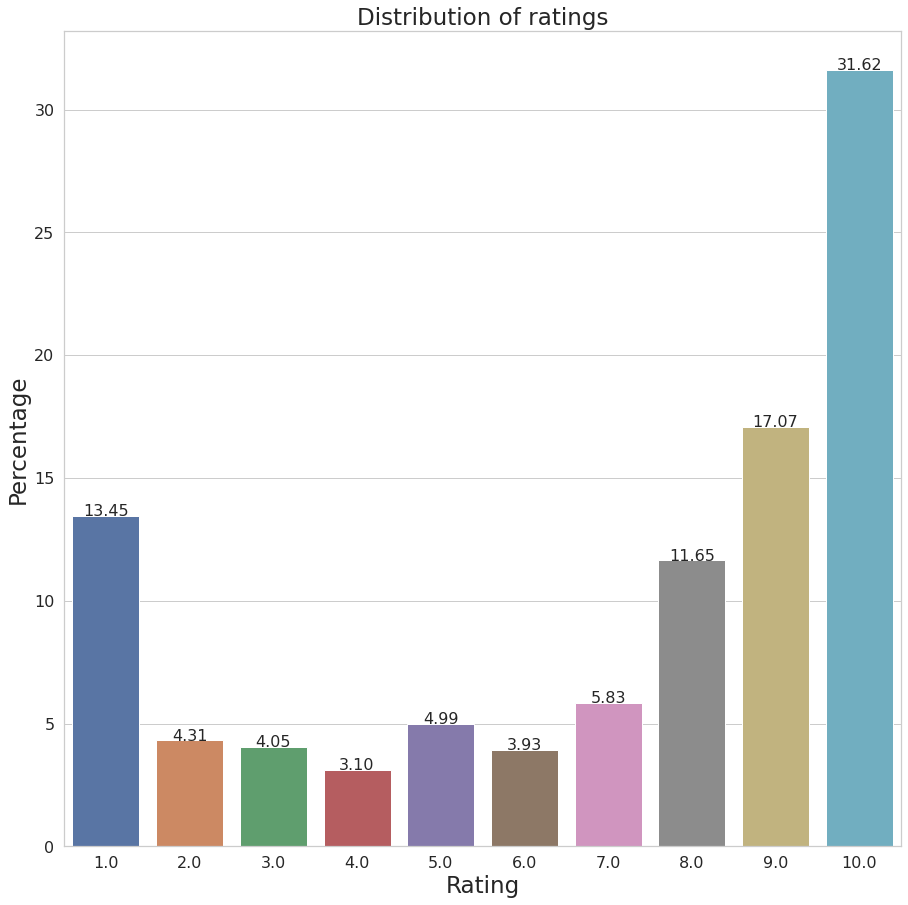

In [5]:
# Function created by Sharon Soussan
# Obtained from https://stackoverflow.com/a/51535326

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
rating_count=df_drugs.groupby('rating').count()
df_drugs.rating.value_counts()
fig, ax = plt.subplots(figsize=(15, 15))
counts = df_drugs.rating.value_counts(normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=ax)
show_values_on_bars(ax)
    
ax.set_xlabel('Rating')
ax.set_ylabel("Percentage")
ax.set_title('Distribution of ratings')
plt.show()

In [6]:
df_drugs.rating.value_counts(normalize=True) * 100

10.0    31.620967
9.0     17.068487
1.0     13.446292
8.0     11.645890
7.0      5.834104
5.0      4.985981
2.0      4.308040
3.0      4.053696
6.0      3.934661
4.0      3.101882
Name: rating, dtype: float64

In [7]:
df_drugs.groupby(['rating']).size().reset_index(name='counts')

,rating,counts
0,1.0,28918
1,2.0,9265
2,3.0,8718
3,4.0,6671
4,5.0,10723
5,6.0,8462
6,7.0,12547
7,8.0,25046
8,9.0,36708
9,10.0,68005


## Preprocessing
When looking at some reviews, e.g.:

In [8]:
print(df_drugs.loc[3660,'review'])
# df_drugs.loc[221320,'review']

28lbs lost in 2.5 months using saxenda (dose between .6-1.2) &amp; following doctor&#039;s guidelines for eating.  Didn&#039;t exercise during the months. I was losing except for physical therapy 1x a week for back.  I&#039;m at a good weight for me (4&#039;11&quot;, 106, age 50) and have been maintaining within 2-4lbs for about 2 mos. now but still using saxenda.  Haven&#039;t been super strict with diet but not going crazy either.  Added light weight training and walking on treadmill 5-6 days a week right before Christmas.  If I overeat a day or 2 I go back to watching and the weight comes right back down.  Thankfully husband&#039;s insurance covers drug because mine doesn&#039;t.  Feel great, cholesterol &amp; blood pressure good again, back is better, and clothes fit.


It can be seen that some of the formatting of the file seems to be wrong, for example representing an apostrophe as "&#039;" or the ampersand as "&amp". The probable cause of this is that the dataset was loaded from HTML, which for example replaces an apostrophe with the previously mentioned value. This can be fixed replacing the values in the dataset with the correct format.

In [9]:
#Contractions removal, based on https://stackoverflow.com/a/47091490
import re   
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"he\'s", "he is", phrase)
    phrase = re.sub(r"she\'s", "she is", phrase)
    phrase = re.sub(r"it\'s", "it is", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
#     phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub('https?://[A-Za-z0-9./]+','', phrase)
    phrase = re.sub(r'www.[^ ]+', '', phrase)
    
    return phrase

unescaper = lambda x: decontracted(html.unescape(x))
df_drugs['review']=df_drugs['review'].apply(unescaper)
df_drugs_train['review']=df_drugs_train['review'].apply(unescaper)
df_drugs_test['review']=df_drugs_test['review'].apply(unescaper)

# df_drugs['review']=df_drugs['review'].apply(phrase())
print(df_drugs.loc[3660, 'review']) #If print is not used, jupyter changes the result and makes it unclear if everything worked ok



28lbs lost in 2.5 months using saxenda (dose between .6-1.2) & following doctor's guidelines for eating.  Did not exercise during the months. I was losing except for physical therapy 1x a week for back.  I am at a good weight for me (4'11", 106, age 50) and have been maintaining within 2-4lbs for about 2 mos. now but still using saxenda.  Have not been super strict with diet but not going crazy either.  Added light weight training and walking on treadmill 5-6 days a week right before Christmas.  If I overeat a day or 2 I go back to watching and the weight comes right back down.  Thankfully husband's insurance covers drug because mine does not.  Feel great, cholesterol & blood pressure good again, back is better, and clothes fit.


In [10]:
df_drugs['total_words'] = df_drugs['review'].str.split().str.len()
df_drugs

,drugName,condition,review,rating,date,usefulCount,total_words
0,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9.0,"May 20, 2012",27,17
1,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8.0,"April 27, 2010",192,141
2,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5.0,"December 14, 2009",17,136
3,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8.0,"November 3, 2015",10,90
4,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9.0,"November 27, 2016",37,127
...,...,...,...,...,...,...,...
215058,Tamoxifen,"Breast Cancer, Prevention",I have taken Tamoxifen for 5 years. Side effec...,10.0,"September 13, 2014",43,96
215059,Escitalopram,Anxiety,I have been taking Lexapro (escitaploprgram) s...,9.0,"October 8, 2016",11,135
215060,Levonorgestrel,Birth Control,"I am married, 34 years old and I have no kids....",8.0,"November 15, 2010",7,151
215061,Tapentadol,Pain,I was prescribed Nucynta for severe neck/shoul...,1.0,"November 28, 2011",20,34


Assigning categories depending on the rating, based on [1]:

In [11]:
def rating_labeler(val):
    if val>neutral_lower_limit:
        if val<neutral_upper_limit:
            lbl="Neutral"
        else:
            lbl="Positive"
    else:
        lbl="Negative"
    return lbl


df_drugs['rating_label'] = df_drugs['rating'].apply(lambda row: rating_labeler(row))

df_drugs_train['rating_label'] = df_drugs_train['rating'].apply(lambda row: rating_labeler(row))

df_drugs_test['rating_label'] = df_drugs_test['rating'].apply(lambda row: rating_labeler(row))

df_drugs.head(10)

,drugName,condition,review,rating,date,usefulCount,total_words,rating_label
0,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9.0,"May 20, 2012",27,17,Positive
1,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8.0,"April 27, 2010",192,141,Positive
2,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5.0,"December 14, 2009",17,136,Neutral
3,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8.0,"November 3, 2015",10,90,Positive
4,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9.0,"November 27, 2016",37,127,Positive
5,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2.0,"November 28, 2015",43,70,Negative
6,Levonorgestrel,Emergency Contraception,"He pulled out, but he cummed a bit in me. I to...",1.0,"March 7, 2017",5,31,Negative
7,Aripiprazole,Bipolar Disorde,Abilify changed my life. There is hope. I was ...,10.0,"March 14, 2015",32,147,Positive
8,Keppra,Epilepsy,I Ve had nothing but problems with the Keppe...,1.0,"August 9, 2016",11,34,Negative
9,Ethinyl estradiol / levonorgestrel,Birth Control,I had been on the pill for many years. When my...,8.0,"December 8, 2016",1,145,Positive


In [12]:
df_drugs.groupby(['rating_label']).size().reset_index(name='counts')

,rating_label,counts
0,Negative,53572
1,Neutral,19185
2,Positive,142306


In [13]:
# Sentiment analysis using VADER [2]:
    
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
def sentiment_analyzer_scores(sentence):
    score = sia.polarity_scores(sentence)
    return score

In [14]:
df_drugs['compound_score'] = df_drugs.apply(lambda row: sentiment_analyzer_scores(row['review'])['compound'], axis=1)

In [15]:
df_drugs.head(20)
#Results seem weird...

,drugName,condition,review,rating,date,usefulCount,total_words,rating_label,compound_score
0,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9.0,"May 20, 2012",27,17,Positive,-0.2960
1,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8.0,"April 27, 2010",192,141,Positive,0.9174
2,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5.0,"December 14, 2009",17,136,Neutral,0.6387
3,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8.0,"November 3, 2015",10,90,Positive,0.7184
4,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9.0,"November 27, 2016",37,127,Positive,0.9403
5,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2.0,"November 28, 2015",43,70,Negative,-0.8972
6,Levonorgestrel,Emergency Contraception,"He pulled out, but he cummed a bit in me. I to...",1.0,"March 7, 2017",5,31,Negative,0.0000
7,Aripiprazole,Bipolar Disorde,Abilify changed my life. There is hope. I was ...,10.0,"March 14, 2015",32,147,Positive,-0.9468
8,Keppra,Epilepsy,I Ve had nothing but problems with the Keppe...,1.0,"August 9, 2016",11,34,Negative,-0.5593
9,Ethinyl estradiol / levonorgestrel,Birth Control,I had been on the pill for many years. When my...,8.0,"December 8, 2016",1,145,Positive,-0.9010


In [16]:
print(df_drugs.loc[7, 'review'])

Abilify changed my life. There is hope. I was on Zoloft and Clonidine when I first started Abilify at the age of 15.. Zoloft for depression and Clondine to manage my complete rage. My moods were out of control. I was depressed and hopeless one second and then mean, irrational, and full of rage the next. My Dr. prescribed me 2mg of Abilify and from that point on I feel like I have been cured though I know I am not.. Bi-polar disorder is a constant battle. I know Abilify works for me because I have tried to get off it and lost complete control over my emotions. Went back on it and I was golden again.  I am on 5mg 2x daily. I am now 21 and better than I have ever been in the past. Only side effect is I like to eat a lot.


Wordcloud taking into account all of the reviews:

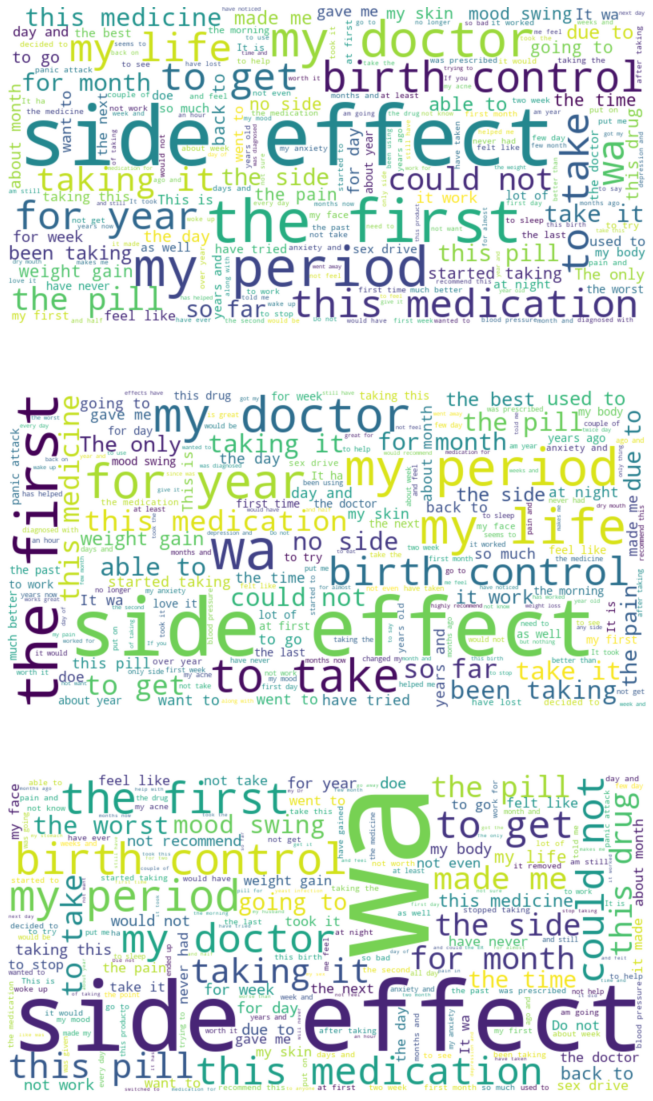

In [17]:
#Wordcloud, based on https://www.datacamp.com/community/tutorials/wordcloud-python
from nltk.corpus import stopwords

def wordClouder(review_txt, bg_color="white"):
    text = " ".join(review for review in review_txt)

    # Create stopword list:
    stop_words = set(stopwords.words('english')) 
    stop_words.update(["also"])

    # Generate a word cloud image
    wc = WordCloud(stopwords = stop_words, width=800, height=400, background_color="white", max_words=200).generate(text)
    return wc

#Vader sentiment classifier binarization as positive and negative
df_drugs_positive=df_drugs[df_drugs['rating_label']=='Positive']
# df_drugs_positive=df_drugs_positive[df_drugs_positive['compound_score']>0.5]

df_drugs_negative=df_drugs[df_drugs['rating_label']=='Negative']
# df_drugs_negative=df_drugs_negative[df_drugs_negative['compound_score']<-0.5]


fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20, 20))
ax1.imshow(wordClouder(df_drugs.review), interpolation='gaussian')
ax1.set_axis_off()
#Positive reviews
ax2.imshow(wordClouder(df_drugs_positive['review']), interpolation='gaussian')
ax2.set_axis_off()
#Negative reviews
ax3.imshow(wordClouder(df_drugs_negative['review']), interpolation='gaussian')
ax3.set_axis_off()

## Feature Generation using Bag of Words
One way of extracting features from text is using the bag of words model. It creates a matrix, called Document-Term Matrix, which has each row representing one of the reviews from the dataset and the columns counting the amount of times each word appeared in said review, similar to what is shown in [https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk].

In [18]:
#Presentation:
#Explanation of tfidf: https://medium.freecodecamp.org/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3

from sklearn.feature_extraction.text import CountVectorizer #https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import TfidfVectorizer #https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
#tokenizer to remove unwanted elements from out data like symbols and numbers

stop_words = set(stopwords.words('english')) 
stop_words.update(["also"])
stop_words.update(["s"])
stop_words.update(["day"])

def textVectorizer(text, vector_type='CountVectorizer', lower_case=False):
    if vector_type=='tfidf':
        token = RegexpTokenizer(r'[a-zA-Z]+')
        tfidf = TfidfVectorizer(lowercase=lower_case, stop_words=stop_words, strip_accents='unicode', 
                             ngram_range = (1,1), tokenizer = token.tokenize)
        tfs = tfidf.fit_transform(text)
        vectorized_text = tfs
        print('textVectorizer: Using TF-IDF for the vectorization')
    elif vector_type=='CountVectorizer':
        token = RegexpTokenizer(r'[a-zA-Z]+')
        cv = CountVectorizer(lowercase=lower_case, stop_words=stop_words, strip_accents='unicode', 
                             ngram_range = (1,1), tokenizer = token.tokenize)
        vectorized_text= cv.fit_transform(text)
        print('textVectorizer: Using CountVectorization for the vectorization\n')
    return vectorized_text

## Train-validate-test split

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

def classification_values(txt_X, txt_y, tst_size=0.2, rnd_state=None, strtfy=None):
    #Evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        txt_X, txt_y, test_size=0.2, random_state=rnd_state, stratify = strtfy)
    
    #Mapping for numerical only classifiers
    mapping = {'Positive':2, 'Neutral':1, 'Negative': 0}
    y_train_mapped = pd.Series(y_train)
    y_train_mapped = y_train_mapped.map(mapping)

    y_test_mapped = pd.Series(y_test)
    y_test_mapped = y_test_mapped.map(mapping)
    
    return X_train, X_test, y_train, y_test, y_train_mapped.values, y_test_mapped.values

# Comparing the VADER Results

In [20]:
#Labeler for multiclassification
def sentiment_labeler(val,limit):
    if val>limit:
        lbl='Positive'
    elif val<-limit:
        lbl='Negative'
    else:
        lbl='Neutral'
    return lbl

# using 0.05 as recommended by VADER labeling score pag 9 book:
df_drugs['compound_label'] = df_drugs['compound_score'].apply(lambda row: sentiment_labeler(row,0.05))
df_drugs.groupby(['compound_label']).size().reset_index(name='counts')

,compound_label,counts
0,Negative,106538
1,Neutral,8527
2,Positive,99998


In [21]:
# Confusion matrix plotting
# Based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.set(style="white")
    label_sizes()
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    sns.set(style="whitegrid")
    label_sizes()
    return ax


np.set_printoptions(precision=2)

precision    recall  f1-score   support

    Negative       0.37      0.74      0.49     53572
     Neutral       0.09      0.04      0.05     19185
    Positive       0.81      0.57      0.67    142306

    accuracy                           0.56    215063
   macro avg       0.42      0.45      0.40    215063
weighted avg       0.64      0.56      0.57    215063



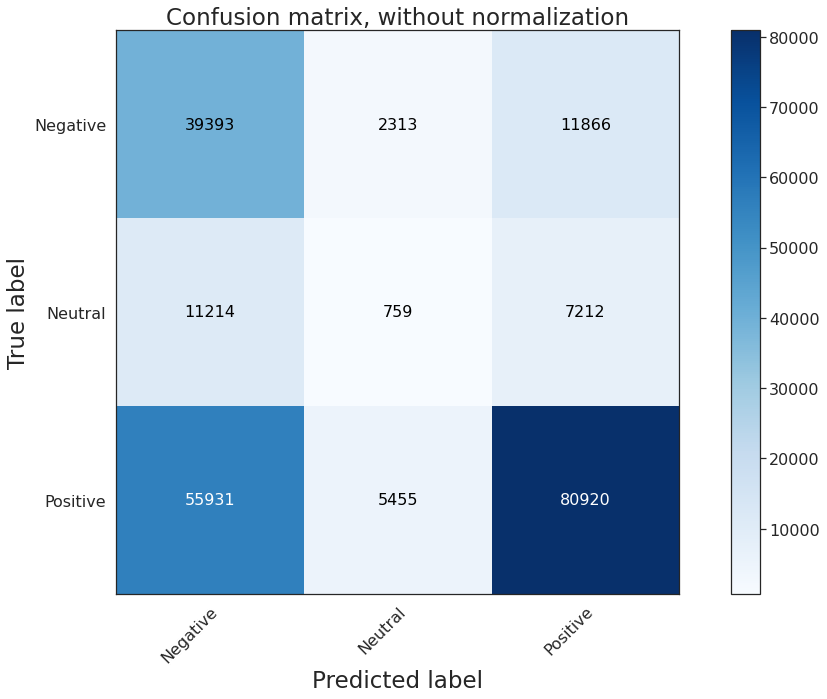

In [22]:
# Comparison between ground truth and VADER
from sklearn import metrics
plot_confusion_matrix(df_drugs['rating_label'], df_drugs['compound_label'], ['Negative', 'Neutral', 'Positive'])
print(metrics.classification_report(df_drugs['rating_label'], df_drugs['compound_label']))

# ML Classification comparison
## With 1-Gram
### Using Count Vectorization

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

# Disabling randomness
np.random.seed(1)

stop_words = set(stopwords.words('english')) 
stop_words.update(["also"])
stop_words.update(["s"])
stop_words.update(["day"])

token = RegexpTokenizer(r'[a-zA-Z]+')
cv = CountVectorizer(lowercase=True, stop_words=stop_words, strip_accents='unicode', 
                     ngram_range = (1,1), tokenizer = token.tokenize)


X_train = cv.fit_transform(df_drugs_train['review'])
X_test = cv.transform(df_drugs_test['review'])

#Mapping for numerical only classifiers
mapping = {'Positive':2, 'Neutral':1, 'Negative': 0}
y_train = pd.Series(df_drugs_train['rating_label'])
y_train = y_train.map(mapping)

y_test = pd.Series(df_drugs_test['rating_label'])
y_test = y_test.map(mapping)

names = ["Logistic Regression", "Linear SVC", "AdaBoost", "Perceptron",  "Nearest Centroid", "Decision Tree", "Random Forest"]

classifiers = [
    LogisticRegression(n_jobs = -1),
    LinearSVC(random_state=1),
    AdaBoostClassifier(),
    Perceptron(n_jobs = -1),
    NearestCentroid(),
    DecisionTreeClassifier(max_depth=20),
    RandomForestClassifier(max_depth=20, n_jobs = -1)
    ]

classifiers_CountVec = []
meanF1 = []
accuracy = []

for classifier, name, i in zip(classifiers, names, range(len(names))):
    print('----------------------------------------------------------------------------------')
    print(name)
    clf = classifier.fit(X_train, y_train)
    classifiers_CountVec.append(clf)
    y_predicted= clf.predict(X_test)
    #Accuracy and classification report
    accuracy.append(metrics.accuracy_score(y_test, y_predicted))
    print(name + " Accuracy:", str(accuracy[i]))
    print(metrics.classification_report(y_test, y_predicted))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, y_predicted))

----------------------------------------------------------------------------------
Logistic Regression
Logistic Regression Accuracy: 0.7927686642115835
              precision    recall  f1-score   support

           0       0.72      0.69      0.70     13497
           1       0.42      0.16      0.23      4829
           2       0.84      0.92      0.88     35440

    accuracy                           0.79     53766
   macro avg       0.66      0.59      0.60     53766
weighted avg       0.77      0.79      0.77     53766

Confusion Matrix: 
[[ 9305   473  3719]
 [ 1379   765  2685]
 [ 2282   604 32554]]
----------------------------------------------------------------------------------
Linear SVC
Linear SVC Accuracy: 0.8164081389725849
              precision    recall  f1-score   support

           0       0.74      0.73      0.74     13497
           1       0.59      0.28      0.38      4829
           2       0.86      0.92      0.89     35440

    accuracy                    

In [24]:
#Sort the classifiers by accuracy
df_names=pd.DataFrame(names)
accuracy=pd.DataFrame(accuracy)
df_scores=pd.concat([df_names, accuracy], axis=1)
df_scores.columns=['Name', 'Accuracy']
df_scores.sort_values(by=['Accuracy'], ascending=False)

,Name,Accuracy
1,Linear SVC,0.816408
0,Logistic Regression,0.792769
3,Perceptron,0.781498
2,AdaBoost,0.716215
5,Decision Tree,0.715341
6,Random Forest,0.659227
4,Nearest Centroid,0.555946


### Using TF-IDF

In [25]:
token = RegexpTokenizer(r'[a-zA-Z]+')
tfidf = TfidfVectorizer(lowercase=True, stop_words=stop_words, strip_accents='unicode', 
                     ngram_range = (1,1), tokenizer = token.tokenize)
        
X_train= tfidf.fit_transform(df_drugs_train['review'])
X_test= tfidf.transform(df_drugs_test['review'])

classifiers_tfidf = []
meanF1 = []
accuracy = []

for classifier, name, i in zip(classifiers, names, range(len(names))):
    print('----------------------------------------------------------------------------------')
    print(name)
    clf = classifier.fit(X_train, y_train)
    classifiers_tfidf.append(clf)
    y_predicted= clf.predict(X_test)
    #Accuracy and classification report
    accuracy.append(metrics.accuracy_score(y_test, y_predicted))
    print(name + " Accuracy:", str(accuracy[i]))
    print(metrics.classification_report(y_test, y_predicted))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, y_predicted))

----------------------------------------------------------------------------------
Logistic Regression
Logistic Regression Accuracy: 0.794293791615519
              precision    recall  f1-score   support

           0       0.73      0.69      0.71     13497
           1       0.38      0.06      0.10      4829
           2       0.82      0.93      0.88     35440

    accuracy                           0.79     53766
   macro avg       0.64      0.56      0.56     53766
weighted avg       0.76      0.79      0.76     53766

Confusion Matrix: 
[[ 9303   218  3976]
 [ 1458   283  3088]
 [ 2069   251 33120]]
----------------------------------------------------------------------------------
Linear SVC
Linear SVC Accuracy: 0.806532009076368
              precision    recall  f1-score   support

           0       0.73      0.73      0.73     13497
           1       0.57      0.10      0.18      4829
           2       0.84      0.93      0.88     35440

    accuracy                      

In [26]:
#Sort the classifiers by accuracy
df_names=pd.DataFrame(names)
accuracy=pd.DataFrame(accuracy)
df_scores=pd.concat([df_names, accuracy], axis=1)
df_scores.columns=['Name', 'Accuracy']
df_scores.sort_values(by=['Accuracy'], ascending=False)

,Name,Accuracy
1,Linear SVC,0.806532
0,Logistic Regression,0.794294
3,Perceptron,0.779972
5,Decision Tree,0.719749
2,AdaBoost,0.717628
6,Random Forest,0.659283
4,Nearest Centroid,0.621824


## With Up to 4-Gram
### Using Count Vectorization

In [27]:
# Disabling randomness
np.random.seed(1)

token = RegexpTokenizer(r'[a-zA-Z]+')
cv = CountVectorizer(lowercase=True, stop_words=stop_words, strip_accents='unicode', 
                     ngram_range = (1,4), tokenizer = token.tokenize)


X_train = cv.fit_transform(df_drugs_train['review'])
X_test = cv.transform(df_drugs_test['review'])

classifiers_CountVec = []
meanF1 = []
accuracy = []

for classifier, name, i in zip(classifiers, names, range(len(names))):
    print('----------------------------------------------------------------------------------')
    print(name)
    clf = classifier.fit(X_train, y_train)
    classifiers_CountVec.append(clf)
    y_predicted= clf.predict(X_test)
    #Accuracy and classification report
    accuracy.append(metrics.accuracy_score(y_test, y_predicted))
    print(name + " Accuracy:", str(accuracy[i]))
    print(metrics.classification_report(y_test, y_predicted))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, y_predicted))

----------------------------------------------------------------------------------
Logistic Regression
Logistic Regression Accuracy: 0.9154670237696686
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     13497
           1       0.93      0.62      0.74      4829
           2       0.93      0.97      0.95     35440

    accuracy                           0.92     53766
   macro avg       0.91      0.82      0.86     53766
weighted avg       0.92      0.92      0.91     53766

Confusion Matrix: 
[[11905   102  1490]
 [  655  2975  1199]
 [  971   128 34341]]
----------------------------------------------------------------------------------
Linear SVC
Linear SVC Accuracy: 0.905386303611948
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     13497
           1       0.87      0.63      0.73      4829
           2       0.93      0.95      0.94     35440

    accuracy                     

In [28]:
#Sort the classifiers by accuracy
df_names=pd.DataFrame(names)
accuracy=pd.DataFrame(accuracy)
df_scores=pd.concat([df_names, accuracy], axis=1)
df_scores.columns=['Name', 'Accuracy']
df_scores.sort_values(by=['Accuracy'], ascending=False)

,Name,Accuracy
3,Perceptron,0.915895
0,Logistic Regression,0.915467
1,Linear SVC,0.905386
2,AdaBoost,0.718316
5,Decision Tree,0.717907
6,Random Forest,0.659153
4,Nearest Centroid,0.560243


### Using TF-IDF

In [29]:
token = RegexpTokenizer(r'[a-zA-Z]+')
tfidf = TfidfVectorizer(lowercase=True, stop_words=stop_words, strip_accents='unicode', 
                     ngram_range = (1,4), tokenizer = token.tokenize)
        
X_train= tfidf.fit_transform(df_drugs_train['review'])
X_test= tfidf.transform(df_drugs_test['review'])

classifiers_tfidf = []
meanF1 = []
accuracy = []

for classifier, name, i in zip(classifiers, names, range(len(names))):
    print('----------------------------------------------------------------------------------')
    print(name)
    clf = classifier.fit(X_train, y_train)
    classifiers_tfidf.append(clf)
    y_predicted= clf.predict(X_test)
    #Accuracy and classification report
    accuracy.append(metrics.accuracy_score(y_test, y_predicted))
    print(name + " Accuracy:", str(accuracy[i]))
    print(metrics.classification_report(y_test, y_predicted))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, y_predicted))

----------------------------------------------------------------------------------
Logistic Regression
Logistic Regression Accuracy: 0.8396570323252613
              precision    recall  f1-score   support

           0       0.83      0.77      0.80     13497
           1       0.74      0.07      0.13      4829
           2       0.84      0.97      0.90     35440

    accuracy                           0.84     53766
   macro avg       0.81      0.60      0.61     53766
weighted avg       0.83      0.84      0.81     53766

Confusion Matrix: 
[[10346    46  3105]
 [ 1137   341  3351]
 [  908    74 34458]]
----------------------------------------------------------------------------------
Linear SVC
Linear SVC Accuracy: 0.917512926384704
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     13497
           1       0.95      0.61      0.75      4829
           2       0.93      0.97      0.95     35440

    accuracy                     

In [30]:
#Sort the classifiers by accuracy
df_names=pd.DataFrame(names)
accuracy=pd.DataFrame(accuracy)
df_scores=pd.concat([df_names, accuracy], axis=1)
df_scores.columns=['Name', 'Accuracy']
df_scores.sort_values(by=['Accuracy'], ascending=False)

,Name,Accuracy
1,Linear SVC,0.917513
3,Perceptron,0.913849
0,Logistic Regression,0.839657
2,AdaBoost,0.716531
5,Decision Tree,0.713239
4,Nearest Centroid,0.659859
6,Random Forest,0.659153


# References
[1] Gräßer, Felix, et al. "Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning." Proceedings of the 2018 International Conference on Digital Health. ACM, 2018.
[2] NLTK Project, "nltk.sentiment.vader -- NLLTK 3.4documentation," Sphinx, 17 November 2015. [Online]. Available: https://www.nltk.org/_modules/nltk/sentiment/vader.html. [Accessed 3 April 2019].